# Countdown Numbers Solver

This is a solver for the Countdown Numbers game. Given 6 numbers, a 3-digit target number, and the operators `+`, `-`, `*`, and `/`, provide a sequence of calculations that will evaluate the target number.

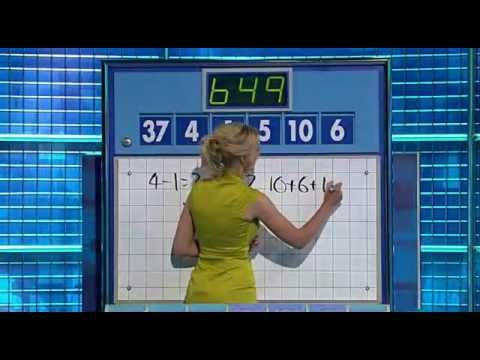

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('9eMs_o08Gm4', width=800, height=300)

## Binary expression tree

The solution can be modeled as a binary expression tree, where each node is one of the operators, and the leaf nodes are the numbers. So you just need to search for a binary expression tree whose root equals the target number. For example, given 62, 12, 7, 5, 1, 10, and the target of 130, the following is a possible solution:

```
          130
           |
           *
          / \
         10  \
              +
             / \
            1  12
```

## Brute force?

One way to solve this is to go through each possible expression tree, and check if it evaluates to the target.

How many possible expressions are there?

```
len(exprs(6)) + len(exprs(5)) + len(exprs(4)) + len(exprs(3)) + len(exprs(2))
= ((6!) * (4^5) * 42) + ((6!/1!) * (4^4) * 14) + ((6!/2!) * (4^3) * 5) + ((6!/3!) * (4^2) * 2) + ((6!/4!) * (4^1) * 1)
= 33,665,400
```

> 42, 14, 5, 2, and 1 are [Catalan numbers](https://en.wikipedia.org/wiki/Catalan_number)

Assuming it takes 1 microsecond to evaluate each expression tree, it will take roughly `33.67/P` seconds to find all possible solutions, where `P` is the number of available parallelism. On a decent computer, this should not take longer than 10s. Not bad actually.


## The algorithm

Instead of brute force, build the expression tree from top-down. You can also do bottom-up, but I chose top-down because I think the search space is smaller.

Say you have 62, 12, 7, 5, 1, 10 and the target of 130.

Cycle through all available numbers and operators. For example, let's say you pick 10 and `*`. Since 130 is divisble by 10, you can build the following tree:

```
          130
           |
           *
          / \
         10  \
              X
```

In the tree above, `X` must be 13. Now you need to figure out how to get 13 from 62, 12, 7, 5, 1. You should notice by now that this is the same problem as above, just that now you only have 5 numbers and a smaller target.

In pseudocode, the algorithm can be written as follows:

```py
def solve(numbers, target, operators):
    for i, num in numbers:
        if num == target:
            return num
        for op in operators:
            # e.g. if num == 10, op == '*', and target == 130,
            # reverse will return 13 if 130 is divisible by 10
            new_target = reverse(num, op, target)
            if new_target > 0:
                # It's the same problem, recurse!
                return solve(numbers.remove(i), new_target, operators)
```

My implementation below roughly does this, but iteratively, and with some (weird) optimizations.

## Future improvements

The code is not perfect.
- The code is a direct translation from a version I wrote in Go, which takes less than a second to complete. This Python version takes up to 10 seconds, probably because of something stupid I'm doing (I'm not that familiar with Python).

- There is a bug where it returns expressions that don't evaluate to the target. This is temporarily fixed by filtering with `eval`.

- The algorithm returns all possible solutions, but some solutions are actually the same (isomorphic?). For example, `(10 * (7 * 3))` and `(3 * (7 * 10))` are redundant because `*` is a commutative operator. It would be better to filter these out.

In [2]:
def solve(numbers, target):
    numbers.sort()

    stack = [(numbers, target)]
    seen = {}
    solution = {}
    solutions = []
    parent = {}

    def update(current, next, expr):
        source = hash(current)
        target = hash(next)

        if target not in parent:
            parent[target] = {}

        parent[target][source] = expr

        if target not in seen:
            seen[target] = True
            stack.append(next)

    while len(stack) > 0:
        current = stack[0]
        stack = stack[1:]
        key = hash(current)

        count = 0
        for num in current[0]:
            if num == 0:
                continue

            count += 1
            if num == current[1]:
                if key not in solution:
                    solutions.append(key)
                solution[key] = True

        if key in solution or count <= 1:
            continue

        for op in ['+', '-', '*', '/']:
            if op == '+':
                for i in range(len(current[0])):
                    left = current[0][i]
                    if left == 0 or left > current[1]:
                        continue

                    next = (without(current[0], i), current[1] - left)
                    expr = "({0} + X)".format(left)
                    update(current, next, expr)

            elif op == '*':
                for i in range(len(current[0])):
                    left = current[0][i]
                    if left <= 1 or left > current[1] or current[1]%left > 0:
                        continue

                    next = (without(current[0], i), current[1] // left)
                    expr = "({0} * X)".format(left)
                    update(current, next, expr)

            elif op == '-':
                for i in range(len(current[0])):
                    num = current[0][i]
                    if num == 0:
                        continue

                    if num > current[1]:
                        next = (without(current[0], i), num - current[1])
                        expr = "({0} - X)".format(num)
                    else:
                        next = (without(current[0], i), num + current[1])
                        expr = "(X - {0})".format(num)

                    update(current, next, expr)

            elif op == '/':
                for i in range(len(current[0])):
                    num = current[0][i]
                    if num == 0:
                        continue

                    if num > current[1] and num%current[1] == 0:
                        next = (without(current[0], i), num // current[1])
                        expr = "({0} // X)".format(num)
                    elif num < current[1] and num > 1:
                        next = (without(current[0], i), num * current[1])
                        expr = "(X // {0})".format(num)
                    else:
                        continue

                    update(current, next, expr)

    exprs = []

    for s in solutions:
        cs = s
        nummask = cs & ((1 << 6) - 1)

        curexpr = ""
        for i in range(len(numbers)):
            if nummask&(1<<i) > 0:
                curexpr = str(numbers[i])
                break

        stack = [(curexpr, cs)]

        while len(stack) > 0:
            cur = stack[0]
            stack = stack[1:]

            nummask = cur[1]&((1 << 6) - 1)
            if nummask != ((1 << 6) - 1):
                m = parent[cur[1]]
                for k in m.keys():
                    expr = m[k]
                    stack.append((expr.replace('X', cur[0]), k))
            else:
                exprs.append(cur[0])

    # TODO: there is a bug, somehow the expression can evaluate
    # to non-target. In the mean time, just filter them out
    exprs = [expr for expr in exprs if int(eval(expr)) == target]
                
    return exprs

def hash(state):
    h = 0
    for i in range(len(state[0])):
        num = state[0][i]
        if num > 0:
            h |= 1 << i

    h |= state[1] << 6
    return h

def without(numbers, i):
    w = numbers.copy()
    w[i] = 0
    return w

In [3]:
%time solutions = solve([62, 12, 7, 5, 1, 10], 130)
for s in solutions:
    print(s)

CPU times: user 3.36 s, sys: 81.4 ms, total: 3.45 s
Wall time: 3.53 s
(10 * (12 + 1))
(10 * (5 + (1 + 7)))
(10 * (5 + (7 + 1)))
(10 * (7 + (5 + 1)))
(10 * (7 + (1 + 5)))
(1 + (7 + (62 + (12 * 5))))
(7 + (1 + (62 + (12 * 5))))
(1 + (62 + (7 + (12 * 5))))
(62 + (1 + (7 + (12 * 5))))
(7 + (62 + (1 + (12 * 5))))
(62 + (7 + (1 + (12 * 5))))
(1 + (10 + (7 * (5 + 12))))
(10 + (1 + (7 * (5 + 12))))
(10 * (7 + ((12 - 5) - 1)))
(10 * ((7 + (12 - 5)) - 1))
(10 * (7 + ((12 - 1) - 5)))
(10 * ((7 + (12 - 1)) - 5))
(10 * (((7 + 12) - 5) - 1))
(10 * (((7 + 12) - 1) - 5))
(1 + (10 + (7 * (12 + 5))))
(10 + (1 + (7 * (12 + 5))))
(10 * (7 + ((12 - 5) - 1)))
(10 * ((7 + (12 - 5)) - 1))
(10 * (7 + (12 - (1 + 5))))
(10 * ((12 + (7 - 5)) - 1))
(5 + (62 + (7 * (10 - 1))))
(62 + (5 + (7 * (10 - 1))))
(7 + (((62 * 10) // 5) - 1))
((7 + ((62 * 10) // 5)) - 1)
(5 + (62 + (7 * (10 - 1))))
(62 + (5 + (7 * (10 - 1))))
(5 + ((12 * (1 + 10)) - 7))
((5 + (12 * (1 + 10))) - 7)
(5 + ((12 * (10 + 1)) - 7))
((5 + (12 * (10 

In [4]:
%time solutions = solve([12, 87, 8, 3, 4, 8], 724)
for s in solutions:
    print(s)

CPU times: user 5.59 s, sys: 55.2 ms, total: 5.64 s
Wall time: 5.65 s
(4 + (8 * (87 + 3)))
(4 + (8 * (87 + 3)))
(8 + ((8 * (87 + 3)) - 4))
((8 + (8 * (87 + 3))) - 4)
(8 + ((8 * (87 + 3)) - 4))
((8 + (8 * (87 + 3))) - 4)
(12 + (8 * (87 + (8 // 3))))
(12 + (8 * (87 + (8 // 3))))
(12 + ((8 * (87 + 3)) - 8))
((12 + (8 * (87 + 3))) - 8)
(12 + ((8 * (87 + 3)) - 8))
((12 + (8 * (87 + 3))) - 8)
((8 * (8 + (87 - 3))) - 12)
((8 * (8 + (87 - 3))) - 12)
((8 * (87 + (8 - 3))) - 12)
((8 * (87 + (8 - 3))) - 12)
((8 * (87 + (12 // 3))) - 4)
((8 * (87 + (12 // 3))) - 4)
(4 + ((8 * (87 + (12 // 3))) - 8))
((4 + (8 * (87 + (12 // 3)))) - 8)
(4 + ((8 * (87 + (12 // 3))) - 8))
((4 + (8 * (87 + (12 // 3)))) - 8)
((8 * (8 + (87 - (12 // 3)))) - 4)
((8 * (8 + (87 - (12 // 3)))) - 4)
((8 * (87 + (8 - (12 // 3)))) - 4)
((8 * (87 + (8 - (12 // 3)))) - 4)
(87 + ((4 * (8 * (8 + 12))) - 3))
((87 + (4 * (8 * (8 + 12)))) - 3)
(87 + ((8 * (4 * (8 + 12))) - 3))
((87 + (8 * (4 * (8 + 12)))) - 3)
(87 + ((4 * (8 * (8 + 12

In [5]:
%time solutions = solve([37, 4, 1, 5, 10, 6], 649)
for s in solutions:
    print(s)

CPU times: user 3.17 s, sys: 33.1 ms, total: 3.21 s
Wall time: 3.21 s
(5 + (4 * ((6 * (37 - 10)) - 1)))
((6 * (1 + (4 * (37 - 10)))) - 5)
(5 + (4 * ((6 * (37 - 10)) - 1)))
((6 * (1 + (4 * (37 - 10)))) - 5)
((5 * (10 * (37 - (4 * 6)))) - 1)
((10 * (5 * (37 - (4 * 6)))) - 1)
((5 * (10 * (37 - (6 * 4)))) - 1)
((10 * (5 * (37 - (6 * 4)))) - 1)
